In [63]:
import re
import string

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
import transformers
from transformers import BertTokenizer
from transformers import TFAutoModel

In [48]:
train = pd.read_csv('twitter_training.csv',encoding='latin-1',usecols =["sentiment","text"])

In [49]:
train

,sentiment,text
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...
...,...,...
74048,Positive,Just realized that the Windows partition of my...
74049,Positive,Just realized that my Mac window partition is ...
74050,Positive,Just realized the windows partition of my Mac ...
74051,Positive,Just realized between the windows partition of...


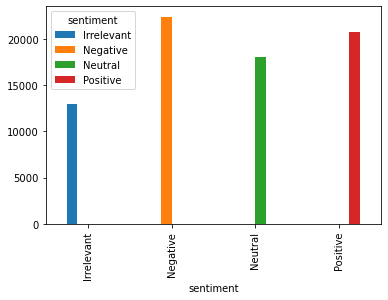

In [50]:
C = ['sentiment']

for i in C:
    ch = pd.crosstab(train[i], train['sentiment'])  
    ch.plot.bar()   
    plt.show() 

In [51]:
labeling = {
    'Positive':1, 
    'Negative':0,
    'Neutral':2,
    'Irrelevant':3,
}

train['sentiment'] = train['sentiment'].apply(lambda x : labeling[x])

In [52]:
train.head(10)

,sentiment,text
0,1,im getting on borderlands and i will murder yo...
1,1,I am coming to the borders and I will kill you...
2,1,im getting on borderlands and i will kill you ...
3,1,im coming on borderlands and i will murder you...
4,1,im getting on borderlands 2 and i will murder ...
5,1,im getting into borderlands and i can murder y...
6,1,So I spent a few hours making something for fu...
7,1,So I spent a couple of hours doing something f...
8,1,So I spent a few hours doing something for fun...
9,1,So I spent a few hours making something for fu...


In [53]:
texts = train.text.values

In [54]:
texts

array(['im getting on borderlands and i will murder you all ,',
       'I am coming to the borders and I will kill you all,',
       'im getting on borderlands and i will kill you all,', ...,
       'Just realized the windows partition of my Mac is now 6 years behind on Nvidia drivers and I have no idea how he didnâ\x80\x99t notice',
       'Just realized between the windows partition of my Mac is like being 6 years behind on Nvidia drivers and cars I have no fucking idea how I ever didn â\x80?t notice',
       'Just like the windows partition of my Mac is like 6 years behind on its drivers So you have no idea how I didnâ\x80\x99t notice'],
      dtype=object)

In [55]:
text.head(10)

0    im getting on borderlands and i will murder yo...
1    I am coming to the borders and I will kill you...
2    im getting on borderlands and i will kill you ...
3    im coming on borderlands and i will murder you...
4    im getting on borderlands 2 and i will murder ...
5    im getting into borderlands and i can murder y...
6    So I spent a few hours making something for fu...
7    So I spent a couple of hours doing something f...
8    So I spent a few hours doing something for fun...
9    So I spent a few hours making something for fu...
Name: text, dtype: object

In [58]:
texts = ["[CLS] " + str(text)+ " [SEP]" for text in texts]

In [59]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in texts]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['[CLS]', 'im', 'getting', 'on', 'border', '##lands', 'and', 'i', 'will', 'murder', 'you', 'all', ',', '[SEP]']


In [60]:
MAX_LEN = 128

In [61]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [64]:
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [65]:
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [68]:
from sklearn.model_selection import train_test_split

labels = train.sentiment.values

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [71]:
import torch
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [73]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [76]:
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

100%|████████████████████████████████████████████████████████████████| 407873900/407873900 [01:55<00:00, 3541252.70B/s]


In [77]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [81]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [{'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],'weight_decay_rate': 0.01},
                                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],'weight_decay_rate': 0.0}]

In [82]:
optimizer = BertAdam(optimizer_grouped_parameters,lr=2e-5,warmup=.1)

t_total value of -1 results in schedule not being applied


In [83]:
from tqdm import tqdm, trange

t = [] 

# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs 
epochs = 2

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    # batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    # batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|                                                                                     | 0/2 [00:09<?, ?it/s]


IndexError: Target 2 is out of bounds.